# Credit Risk Resampling Techniques

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

# Read the CSV and Perform Basic Data Cleaning

In [4]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('../Data/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

loan_amnt  int_rate  installment home_ownership  annual_inc  \
0    10500.0    0.1719       375.35           RENT     66000.0   
1    25000.0    0.2000       929.09       MORTGAGE    105000.0   
2    20000.0    0.2000       529.88       MORTGAGE     56000.0   
3    10000.0    0.1640       353.55           RENT     92000.0   
4    22000.0    0.1474       520.39       MORTGAGE     52000.0   

  verification_status   issue_d loan_status pymnt_plan    dti  ...  \
0     Source Verified  Mar-2019    low_risk          n  27.24  ...   
1            Verified  Mar-2019    low_risk          n  20.23  ...   
2            Verified  Mar-2019    low_risk          n  24.26  ...   
3            Verified  Mar-2019    low_risk          n  31.44  ...   
4        Not Verified  Mar-2019    low_risk          n  18.76  ...   

   pct_tl_nvr_dlq  percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  \
0            85.7             100.0                   0.0        0.0   
1            91.2              50.0                   1.0        0.0   
2            66.7              50.0                   0.0        0.0   
3           100.0              50.0                   1.0        0.0   
4           100.0               0.0                   0.0        0.0   

   tot_hi_cred_lim  total_bal_ex_mort total_bc_limit  \
0          65687.0            38199.0         2000.0   
1         271427.0            60641.0        41200.0   
2          60644.0            45684.0         7500.0   
3          99506.0            68784.0        19700.0   
4         219750.0            25919.0        27600.0   

   total_il_high_credit_limit  hardship_flag  debt_settlement_flag  
0                     61987.0              N                     N  
1                     49197.0              N                     N  
2                     43144.0              N                     N  
3                     76506.0              N                     N  
4                     20000.0              N                     N  

[5 rows x 86 columns]

# Split the Data into Training and Testing

In [6]:
# Create our features
X = df.copy()
X.drop("loan_status", axis=1, inplace=True)

# Create our target
y = df["loan_status"]

In [7]:
X.describe(include='all')

loan_amnt      int_rate   installment home_ownership    annual_inc  \
count   68817.000000  68817.000000  68817.000000          68817  6.881700e+04   
unique           NaN           NaN           NaN              4           NaN   
top              NaN           NaN           NaN       MORTGAGE           NaN   
freq             NaN           NaN           NaN          36219           NaN   
mean    16677.594562      0.127718    480.652863            NaN  8.821371e+04   
std     10277.348590      0.048130    288.062432            NaN  1.155800e+05   
min      1000.000000      0.060000     30.890000            NaN  4.000000e+01   
25%      9000.000000      0.088100    265.730000            NaN  5.000000e+04   
50%     15000.000000      0.118000    404.560000            NaN  7.300000e+04   
75%     24000.000000      0.155700    648.100000            NaN  1.040000e+05   
max     40000.000000      0.308400   1676.230000            NaN  8.797500e+06   

       verification_status   issue_d pymnt_plan           dti   delinq_2yrs  \
count                68817     68817      68817  68817.000000  68817.000000   
unique                   3         3          1           NaN           NaN   
top           Not Verified  Jan-2019          n           NaN           NaN   
freq                 32895     31041      68817           NaN           NaN   
mean                   NaN       NaN        NaN     21.778153      0.217766   
std                    NaN       NaN        NaN     20.199244      0.718367   
min                    NaN       NaN        NaN      0.000000      0.000000   
25%                    NaN       NaN        NaN     13.890000      0.000000   
50%                    NaN       NaN        NaN     19.760000      0.000000   
75%                    NaN       NaN        NaN     26.660000      0.000000   
max                    NaN       NaN        NaN    999.000000     18.000000   

        ...  pct_tl_nvr_dlq  percent_bc_gt_75  pub_rec_bankruptcies  \
count   ...    68817.000000      68817.000000          68817.000000   
unique  ...             NaN               NaN                   NaN   
top     ...             NaN               NaN                   NaN   
freq    ...             NaN               NaN                   NaN   
mean    ...       95.057627         30.626217              0.125972   
std     ...        8.326426         33.631463              0.336732   
min     ...       20.000000          0.000000              0.000000   
25%     ...       93.000000          0.000000              0.000000   
50%     ...      100.000000         20.000000              0.000000   
75%     ...      100.000000         50.000000              0.000000   
max     ...      100.000000        100.000000              4.000000   

        tax_liens  tot_hi_cred_lim total_bal_ex_mort  total_bc_limit  \
count     68817.0     6.881700e+04      6.881700e+04    68817.000000   
unique        NaN              NaN               NaN             NaN   
top           NaN              NaN               NaN             NaN   
freq          NaN              NaN               NaN             NaN   
mean          0.0     2.100332e+05      6.133843e+04    29734.128558   
std           0.0     1.928088e+05      5.738798e+04    26795.394232   
min           0.0     3.600000e+03      2.350000e+02      100.000000   
25%           0.0     6.697700e+04      2.650300e+04    11600.000000   
50%           0.0     1.467100e+05      4.535700e+04    22100.000000   
75%           0.0     3.036400e+05      7.657000e+04    39300.000000   
max           0.0     3.292782e+06      1.295455e+06   509400.000000   

        total_il_high_credit_limit  hardship_flag  debt_settlement_flag  
count                 6.881700e+04          68817                 68817  
unique                         NaN              1                     1  
top                            NaN              N                     N  
freq                           NaN          68817                 68817  
m

In [8]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [9]:
df.select_dtypes(include='object').head(10)

home_ownership verification_status   issue_d loan_status pymnt_plan  \
0           RENT     Source Verified  Mar-2019    low_risk          n   
1       MORTGAGE            Verified  Mar-2019    low_risk          n   
2       MORTGAGE            Verified  Mar-2019    low_risk          n   
3           RENT            Verified  Mar-2019    low_risk          n   
4       MORTGAGE        Not Verified  Mar-2019    low_risk          n   
5       MORTGAGE     Source Verified  Mar-2019    low_risk          n   
6           RENT     Source Verified  Mar-2019    low_risk          n   
7            OWN     Source Verified  Mar-2019    low_risk          n   
8           RENT        Not Verified  Mar-2019    low_risk          n   
9           RENT            Verified  Mar-2019    low_risk          n   

  initial_list_status next_pymnt_d application_type hardship_flag  \
0                   w     May-2019       Individual             N   
1                   w     May-2019       Individual             N   
2                   w     May-2019       Individual             N   
3                   w     May-2019       Individual             N   
4                   w     May-2019       Individual             N   
5                   w     May-2019       Individual             N   
6                   w     May-2019       Individual             N   
7                   w     May-2019       Individual             N   
8                   f     May-2019       Individual             N   
9                   w     May-2019       Individual             N   

  debt_settlement_flag  
0                    N  
1                    N  
2                    N  
3                    N  
4                    N  
5                    N  
6                    N  
7                    N  
8                    N  
9                    N

In [10]:
X = pd.get_dummies(X, columns=["home_ownership", "verification_status", "issue_d", 
                               "pymnt_plan","initial_list_status", "next_pymnt_d", 
                               "application_type", "hardship_flag", "debt_settlement_flag"])

X.head(10)

loan_amnt  int_rate  installment  annual_inc    dti  delinq_2yrs  \
0    10500.0    0.1719       375.35     66000.0  27.24          0.0   
1    25000.0    0.2000       929.09    105000.0  20.23          0.0   
2    20000.0    0.2000       529.88     56000.0  24.26          0.0   
3    10000.0    0.1640       353.55     92000.0  31.44          0.0   
4    22000.0    0.1474       520.39     52000.0  18.76          0.0   
5    25000.0    0.1797       634.43     90000.0  18.49          1.0   
6    20400.0    0.2000       540.48     51315.0  25.63          0.0   
7    10000.0    0.1557       349.46     66000.0   9.00          0.0   
8    14000.0    0.0881       443.96     45000.0  10.24          0.0   
9    10000.0    0.1474       345.39     63295.0  39.34          0.0   

   inq_last_6mths  open_acc  pub_rec  revol_bal  ...  issue_d_Mar-2019  \
0             0.0       8.0      0.0     1609.0  ...                 1   
1             0.0      17.0      1.0    18368.0  ...                 1   
2             0.0       8.0      0.0    13247.0  ...                 1   
3             1.0      10.0      1.0    17996.0  ...                 1   
4             1.0      14.0      0.0     9091.0  ...                 1   
5             1.0      14.0      0.0    23889.0  ...                 1   
6             2.0       8.0      1.0     2569.0  ...                 1   
7             0.0      11.0      0.0     9407.0  ...                 1   
8             1.0       9.0      0.0     7058.0  ...                 1   
9             0.0      27.0      0.0    25790.0  ...                 1   

   pymnt_plan_n  initial_list_status_f  initial_list_status_w  \
0             1                      0                      1   
1             1                      0                      1   
2             1                      0                      1   
3             1                      0                      1   
4             1                      0                      1   
5             1                      0                      1   
6             1                      0                      1   
7             1                      0                      1   
8             1                      1                      0   
9             1                      0                      1   

   next_pymnt_d_Apr-2019  next_pymnt_d_May-2019  application_type_Individual  \
0                      0                      1                            1   
1                      0                      1                            1   
2                      0                      1                            1   
3                      0                      1                            1   
4                      0                      1                            1   
5                      0                      1                            1   
6                      0                      1                            1   
7                      0                      1                            1   
8                      0                      1                            1   
9                      0                      1                            1   

   application_type_Joint App  hardship_flag_N  debt_settlement_flag_N  
0                           0                1                       1  
1                           0                1                       1  
2                           0                1                       1  
3                           0                1                       1  
4                           0                1                       1  
5                           0                1                       1  
6                           0                1                       1  
7                           0                1                       1  
8                           0                1                       1  
9                           0                1                       1  

[10 r

<details>
    <summary>Alternatively, we can manually encode to adjust the outcome from LabelEncoder shown below: </summary>

<blockquote>
    
``` python
from sklearn.preprocessing import LabelEncoder

#Create the LabelEncoder instance
le = LabelEncoder()

#Fitting and encoding the columns with => 2 values with the LabelEncoder

le.fit(X["home_ownership"])
X["home_ownership"] = le.transform(X["home_ownership"])

le.fit(X["verification_status"])
X["verification_status"] = le.transform(X["verification_status"])

le.fit(X["issue_d"])
X["issue_d"] = le.transform(X["issue_d"])

le.fit(X["pymnt_plan"])
X["pymnt_plan"] = le.transform(X["pymnt_plan"])

le.fit(X["initial_list_status"])
X["initial_list_status"] = le.transform(X["initial_list_status"])

le.fit(X["next_pymnt_d"])
X["next_pymnt_d"] = le.transform(X["next_pymnt_d"])

le.fit(X["application_type"])
X["application_type"] = le.transform(X["application_type"])

le.fit(X["hardship_flag"])
X["hardship_flag"] = le.transform(X["hardship_flag"])

le.fit(X["debt_settlement_flag"])
X["debt_settlement_flag"] = le.transform(X["debt_settlement_flag"])
```
</blockquote>
</details>

In [11]:
# Check that there is no more categorical data
X.select_dtypes(include='object').head()

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

In [12]:
# Create X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [14]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [15]:
# Scale the training data - only scale X_train and X_test data 
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [16]:
# Resample the training data with the RandomOversampler
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

# Note: '1' represents 'low_risk' and '0' represents 'high_risk'

Using TensorFlow backend.


Counter({'low_risk': 51369, 'high_risk': 51369})

In [17]:
# Train the Logistic Regression model using the resampled data
# Logistic regression using random oversampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=42)
model.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.8301954901422769

In [19]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

print("Confusion Matrix - Oversampling")
confusion_matrix(y_test, y_pred)

Confusion Matrix - Oversampling


array([[   84,    20],
       [ 2519, 14582]])

In [20]:
# Print the imbalanced classification report
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print("Classification Report - Oversampling")
print(classification_report_imbalanced(y_test, y_pred))

Classification Report - Oversampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.81      0.85      0.06      0.83      0.69       104
   low_risk       1.00      0.85      0.81      0.92      0.83      0.69     17101

avg / total       0.99      0.85      0.81      0.91      0.83      0.69     17205



### SMOTE Oversampling

In [21]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=42, sampling_strategy=1.0).fit_resample(
    X_train, y_train
)
from collections import Counter

Counter(y_resampled)

Counter({'low_risk': 51369, 'high_risk': 51369})

In [22]:
# Train the Logistic Regression model using the resampled data
model_smote = LogisticRegression(solver='lbfgs', random_state=42)
model_smote.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# Calculated the balanced accuracy score
y_pred = model_smote.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.8085877231650871

In [24]:
# Display the confusion matrix

print("Confusion Matrix - SMOTE Oversampling")
confusion_matrix(y_test, y_pred)

Confusion Matrix - SMOTE Oversampling


array([[   77,    27],
       [ 2107, 14994]])

In [25]:
# Print the imbalanced classification report
print("Classification Report - SMOTE Oversampling")
print(classification_report_imbalanced(y_test, y_pred))

Classification Report - SMOTE Oversampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.74      0.88      0.07      0.81      0.64       104
   low_risk       1.00      0.88      0.74      0.93      0.81      0.66     17101

avg / total       0.99      0.88      0.74      0.93      0.81      0.66     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [26]:
# Resample the data using the ClusterCentroids resampler
# Fit the data using `ClusterCentroids` and check the count of each class
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=42)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

from collections import Counter

Counter(y_resampled)

Counter({'high_risk': 243, 'low_risk': 243})

In [27]:
# Train the Logistic Regression model using the resampled data
# Logistic regression using cluster centroid undersampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=42)
model.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8085877231650871

In [29]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

print("Confusion Matrix - Undersampling")
confusion_matrix(y_test, y_pred)

Confusion Matrix - Undersampling


array([[   85,    19],
       [ 4066, 13035]])

In [30]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print("Classification Report - Undersampling")
print(classification_report_imbalanced(y_test, y_pred))

Classification Report - Undersampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.82      0.76      0.04      0.79      0.63       104
   low_risk       1.00      0.76      0.82      0.86      0.79      0.62     17101

avg / total       0.99      0.76      0.82      0.86      0.79      0.62     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [33]:
# Resample the training data with SMOTEENN
# Count the resampled classes
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'high_risk': 68455, 'low_risk': 62028})

In [34]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model_smoteenn = LogisticRegression(solver='lbfgs', random_state=42)
model_smoteenn.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.7897719094249999

In [36]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model_smoteenn.predict(X_test)

print("Confusion Matrix - SMOTEENN Over and Undersampling")
confusion_matrix(y_test, y_pred)

Confusion Matrix - SMOTEENN Over and Undersampling


array([[   86,    18],
       [11049,  6052]])

In [37]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print("Classification Report - SMOTEENN Over and Undersampling on Imbalanced Data")
print(classification_report_imbalanced(y_test, y_pred))

Classification Report - SMOTEENN Over and Undersampling on Imbalanced Data
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.83      0.35      0.02      0.54      0.31       104
   low_risk       1.00      0.35      0.83      0.52      0.54      0.28     17101

avg / total       0.99      0.36      0.82      0.52      0.54      0.28     17205



# SVM Model 
### _*Additional Test*_

In [38]:
# Instantiate a linear SVM model
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
# Fit the data
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
# Score the accuracy
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9952917926063706
Testing Data Score: 0.9939552455681488


In [41]:
# Make predictions using the test data
predictions = classifier.predict(X_test)
results = pd.DataFrame({
    "Prediction": predictions, 
    "Actual": y_test
}).reset_index(drop=True)
results.head()

Prediction    Actual
0   low_risk  low_risk
1   low_risk  low_risk
2   low_risk  low_risk
3   low_risk  low_risk
4   low_risk  low_risk

In [42]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.5904102549108688

In [43]:
from sklearn.metrics import confusion_matrix

print("Confusion Matrix - SVM")
confusion_matrix(y_test, predictions)

Confusion Matrix - SVM


array([[    0,   104],
       [    0, 17101]])

In [44]:
from sklearn.metrics import classification_report

print("Classification Report - SVM")
print(classification_report(y_test, predictions))

Classification Report - SVM
              precision    recall  f1-score   support

   high_risk       0.00      0.00      0.00       104
    low_risk       0.99      1.00      1.00     17101

    accuracy                           0.99     17205
   macro avg       0.50      0.50      0.50     17205
weighted avg       0.99      0.99      0.99     17205



# Decision Tree
### _*Additional Test*_

In [45]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test)

In [46]:
# Evaluating the decision tree model

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [47]:
# Displaying results
print("Confusion Matrix - Decision Tree")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report - Decision Tree")
print(classification_report(y_test, predictions))

Confusion Matrix - Decision Tree


Predicted 0  Predicted 1
Actual 0           46           58
Actual 1           62        17039

Accuracy Score : 0.993025283347864
Classification Report - Decision Tree
              precision    recall  f1-score   support

   high_risk       0.43      0.44      0.43       104
    low_risk       1.00      1.00      1.00     17101

    accuracy                           0.99     17205
   macro avg       0.71      0.72      0.72     17205
weighted avg       0.99      0.99      0.99     17205



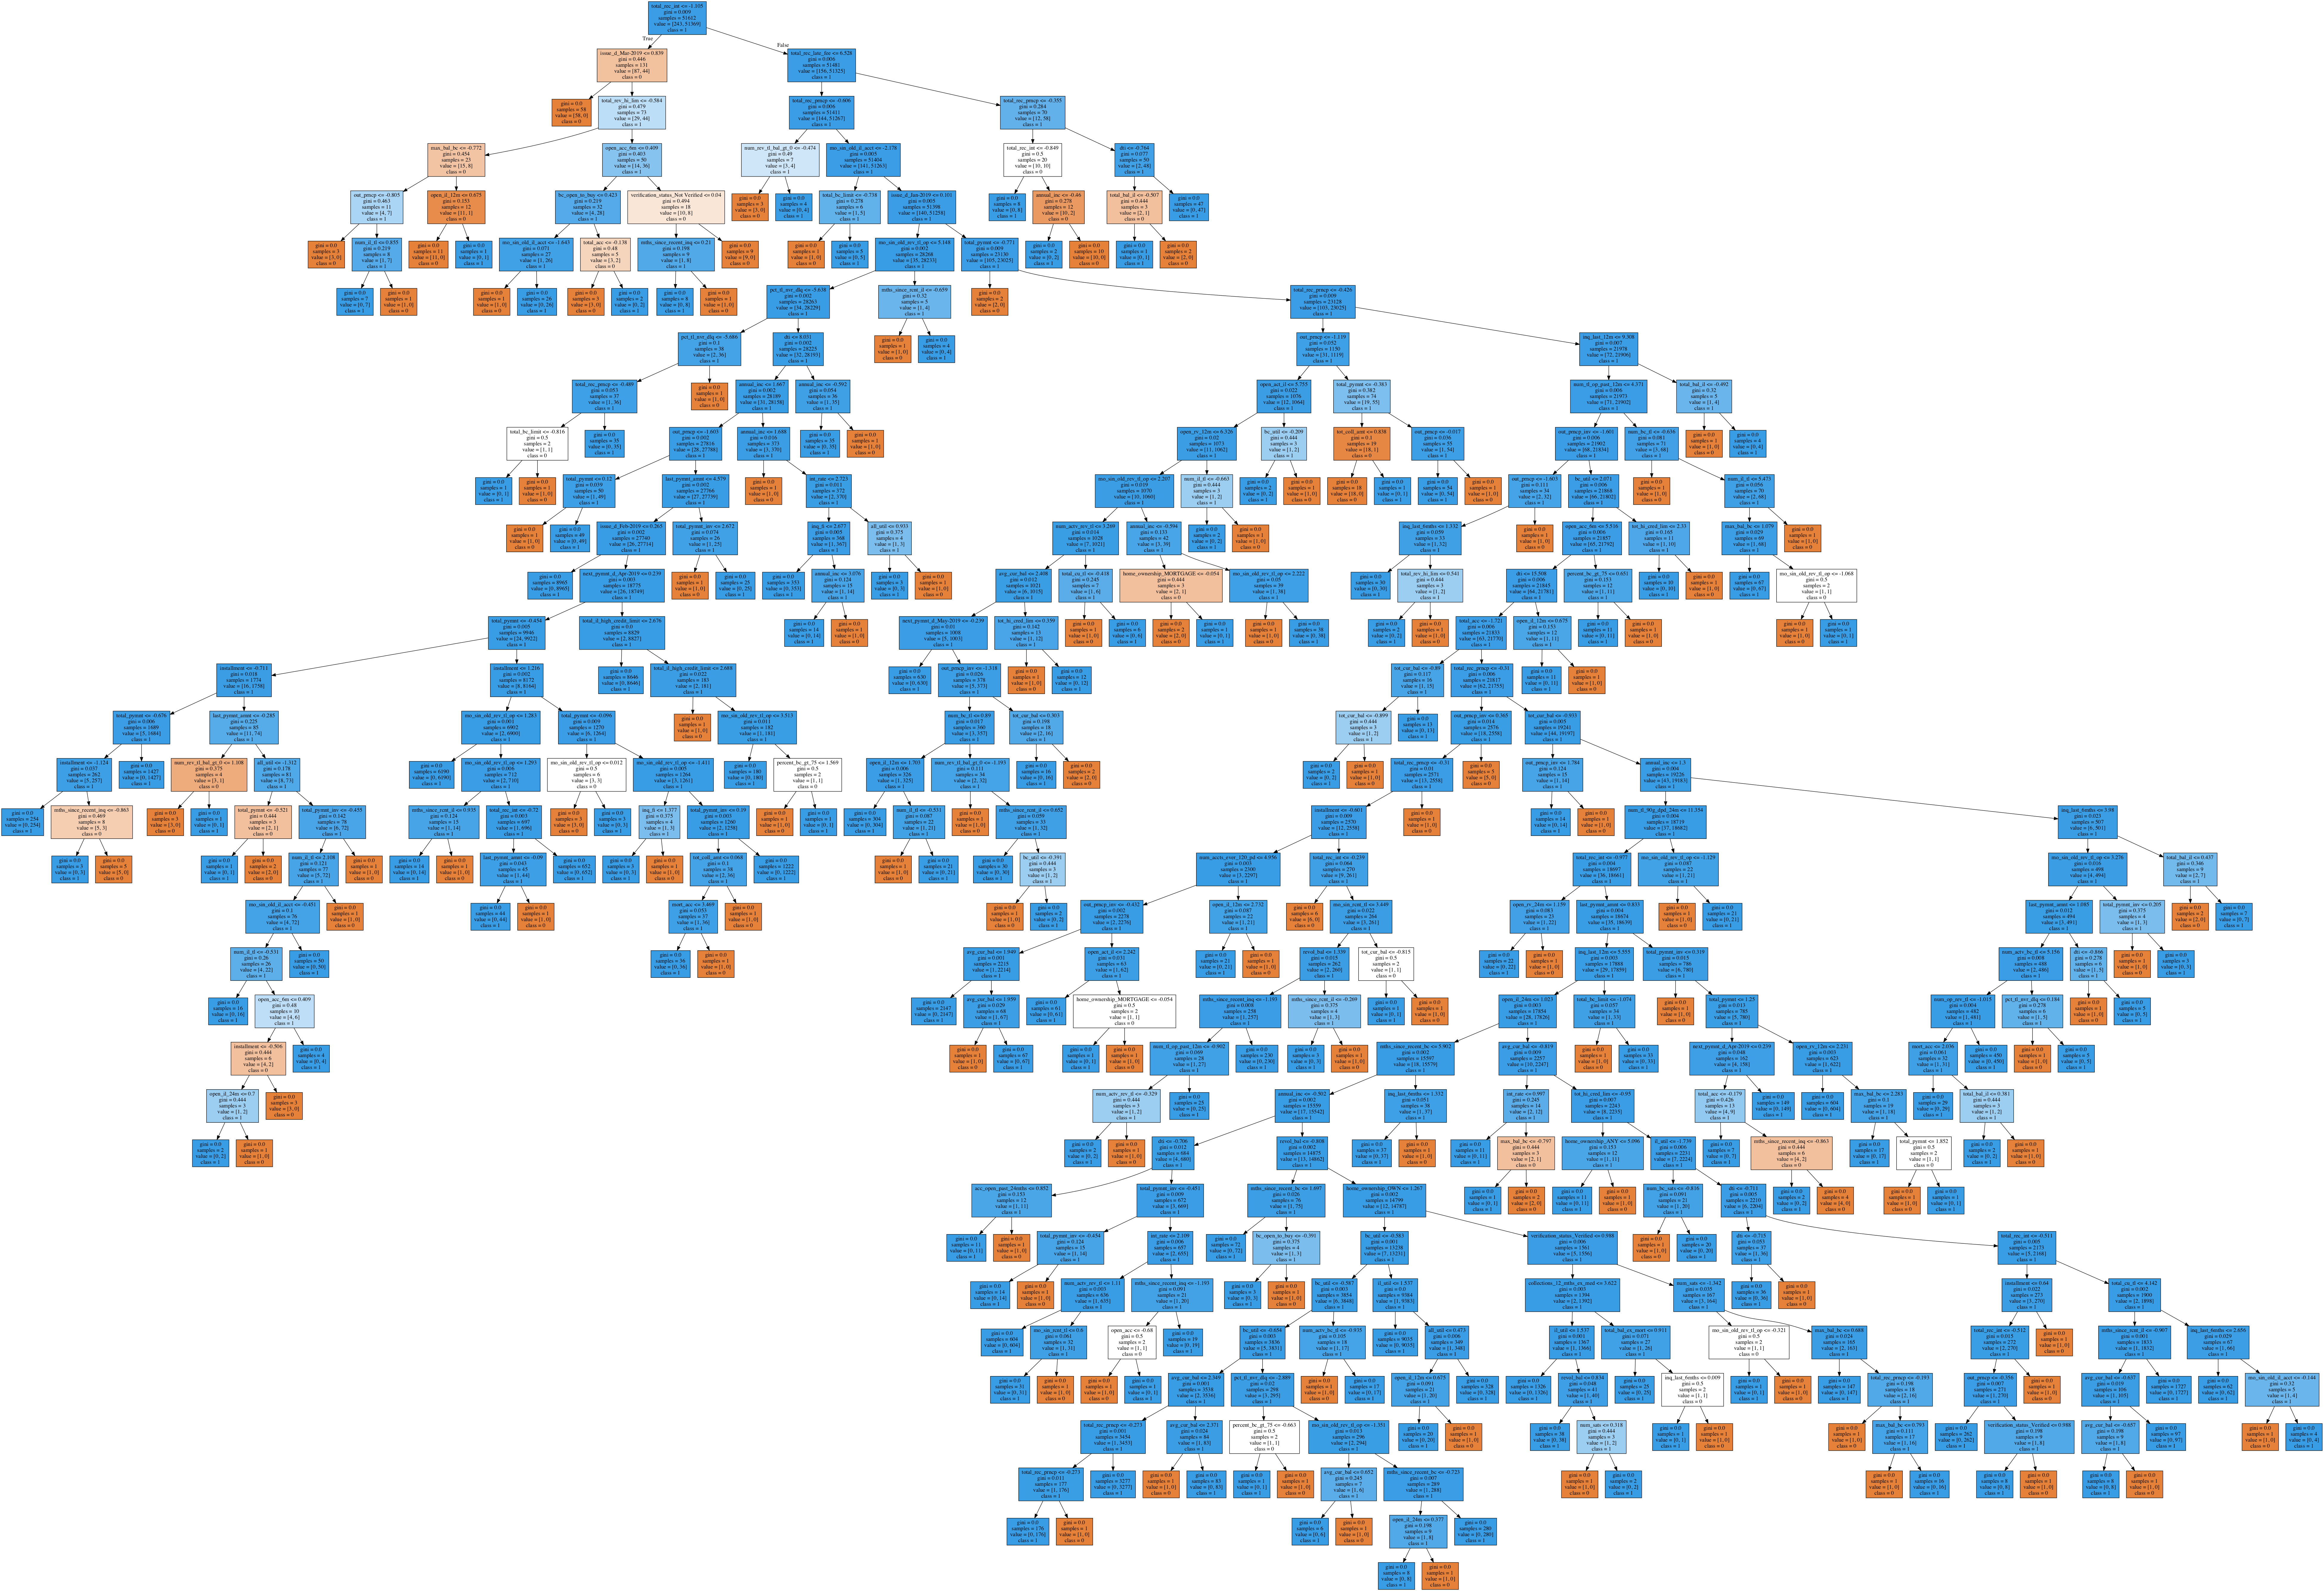

In [48]:
# Tree Visualization

# Graph tree
from sklearn import tree

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

# Create DOT data
dot_data = tree.export_graphviz(
    model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [50]:
# Saving the tree as PDF
graph.write_pdf("../Images/decision_tree.pdf")

# Saving the tree as PNG
graph.write_png("../Images/decision_tree.png")

True